In [3]:
!pip install transformers

     |████████████████████████████████| 1.5MB 4.3MB/s 
     |████████████████████████████████| 2.9MB 37.7MB/s 
     |████████████████████████████████| 890kB 35.4MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=e85a1c7241f6af45c2b2d629a6e1d1b40190fb13f61784ec72b05b4393d69a82
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [4]:
import torch
from tqdm.notebook import tqdm

from transformers import BertTokenizer
from torch.utils.data import TensorDataset

from transformers import BertForSequenceClassification

In [5]:
# imports
import numpy as np
import pandas as pd

# set pandas to display the maximum range if necessary
pd.set_option("display.max_rows", None, "display.max_columns", None, "display.max_colwidth", None)
pd.options.mode.chained_assignment = None  # default='warn'

df = pd.read_json (r'/content/drive/MyDrive/Colab Notebooks/emotion_data/unified-dataset.json', lines=True)
set(df['source'])

{'affectivetext',
 'crowdflower',
 'dailydialogues',
 'electoraltweets',
 'emoint',
 'emotion-cause',
 'emotiondata-aman',
 'fb-valence-arousal-anon',
 'grounded_emotions',
 'isear',
 'ssec',
 'tales-emotion',
 'tec'}

In [6]:
print(len(df.loc[df['source'] == 'isear']))
df_isear = df.loc[df['source'] == 'isear']
df_isear[:1]

7666


,id,VAD,source,text,emotions,split,emotion_model,annotation_procedure,domain,labeled,optional
146188,146188,"{'valence': None, 'arousal': None, 'dominance': None}",isear,"During the period of falling in love, each time that we met and especially when we had not met for a long time.","{'joy': 1, 'anger': 0, 'sadness': 0, 'disgust': 0, 'fear': 0, 'trust': None, 'surprise': None, 'love': None, 'noemo': None, 'confusion': None, 'anticipation': None, 'shame': 0, 'guilt': 0}",None,NaN,NaN,emotional_events,single,NaN


In [7]:
emotions = df_isear['emotions']
target_emotions = []
for index in emotions:
    foo = {k: index[k] for k in index.keys() & {'joy', 'anger', 'sadness', 'disgust','fear'}}
    if all(value == 0 for value in foo.values()):
        foo = 'None'
    else:
        foo = list(foo.keys())[list(foo.values()).index(1)]
    target_emotions.append(foo)
df_isear['target_emotions']= pd.Series(target_emotions).values
df_isear = df_isear.drop(['id', 'VAD', 'source', 'emotions', 'split', 'emotion_model', 'annotation_procedure', 'domain', 'labeled', 'optional'], axis=1)
df_isear[:2]

,text,target_emotions
146188,"During the period of falling in love, each time that we met and especially when we had not met for a long time.",joy
146189,When I was involved in a traffic accident.,fear


In [8]:
indexNames = df_isear[df_isear['target_emotions'] == 'None'].index
df_isear.drop(indexNames , inplace=True)
df_isear[:2]

,text,target_emotions
146188,"During the period of falling in love, each time that we met and especially when we had not met for a long time.",joy
146189,When I was involved in a traffic accident.,fear


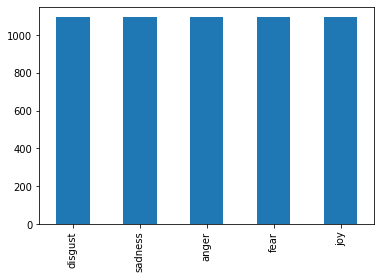

In [9]:
df_isear['target_emotions'].value_counts().plot(kind='bar')

In [10]:
possible_labels = df_isear.target_emotions.unique()

label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index
label_dict

{'anger': 2, 'disgust': 4, 'fear': 1, 'joy': 0, 'sadness': 3}

In [11]:
df_isear['label'] = df_isear.target_emotions.replace(label_dict)
df_isear.head()

,text,target_emotions,label
146188,"During the period of falling in love, each time that we met and especially when we had not met for a long time.",joy,0
146189,When I was involved in a traffic accident.,fear,1
146190,"When I was driving home after several days of hard work, there was a motorist ahead of me who was driving at 50 km/hour and refused, despite his low speeed to let me overtake.",anger,2
146191,When I lost the person who meant the most to me.,sadness,3
146192,"The time I knocked a deer down - the sight of the animal's injuries and helplessness. The realization that the animal was so badly hurt that it had to be put down, and when the animal screamed at the moment of death.",disgust,4


In [12]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(df_isear.index.values, 
                                                  df_isear.label.values, 
                                                  test_size=0.15, 
                                                  random_state=42, 
                                                  stratify=df_isear.label.values)
df_isear['data_type'] = ['not_set']*df_isear.shape[0]

df_isear.loc[X_train, 'data_type'] = 'train'
df_isear.loc[X_val, 'data_type'] = 'val'
df_isear.groupby(['target_emotions', 'label', 'data_type']).count()

text
target_emotions label data_type      
anger           2     train       932
                      val         164
disgust         4     train       931
                      val         165
fear            1     train       931
                      val         164
joy             0     train       930
                      val         164
sadness         3     train       931
                      val         165

In [13]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', 
                                          do_lower_case=True)

In [14]:
encoded_data_train = tokenizer.batch_encode_plus(
    df_isear[df_isear.data_type=='train'].text.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt'
)

encoded_data_val = tokenizer.batch_encode_plus(
    df_isear[df_isear.data_type=='val'].text.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt'
)


input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(df_isear[df_isear.data_type=='train'].label.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(df_isear[df_isear.data_type=='val'].label.values)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2179: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [15]:
dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

In [16]:
len(dataset_train), len(dataset_val)

(4655, 822)

In [17]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [18]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 3

dataloader_train = DataLoader(dataset_train, 
                              sampler=RandomSampler(dataset_train), 
                              batch_size=batch_size)

dataloader_validation = DataLoader(dataset_val, 
                                   sampler=SequentialSampler(dataset_val), 
                                   batch_size=batch_size)

In [19]:
from transformers import AdamW, get_linear_schedule_with_warmup

optimizer = AdamW(model.parameters(),
                  lr=1e-5, 
                  eps=1e-8)

In [20]:
epochs = 3

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*epochs)

In [21]:
from sklearn.metrics import f1_score

def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

In [22]:
import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [23]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(device)

cpu


In [24]:
def evaluate(dataloader_val):

    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals

In [ ]:
for epoch in tqdm(range(1, epochs+1)):
    
    torch.save(model.state_dict(), f'/content/drive/MyDrive/Colab Notebooks/emotion_data/finetuned_BERT_isear_epoch_{epoch}.model')

    model.train()
    
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       

        outputs = model(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
          
    torch.save(model.state_dict(), f'/content/drive/MyDrive/Colab Notebooks/emotion_data/finetuned_BERT_isear_epoch_{epoch}.model')
        
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')



Epoch 1
Training loss: 0.9278539589806651
Validation loss: 0.623195191264071
F1 Score (Weighted): 0.8037690943889814


In [25]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [26]:
model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/emotion_data/finetuned_BERT_isear_epoch_1.model', map_location=torch.device('cpu')))

<All keys matched successfully>

In [27]:
_, predictions, true_vals = evaluate(dataloader_validation)

In [28]:
accuracy_per_class(predictions, true_vals)

Class: joy
Accuracy: 151/164

Class: fear
Accuracy: 131/164

Class: anger
Accuracy: 113/164

Class: sadness
Accuracy: 136/165

Class: disgust
Accuracy: 129/165



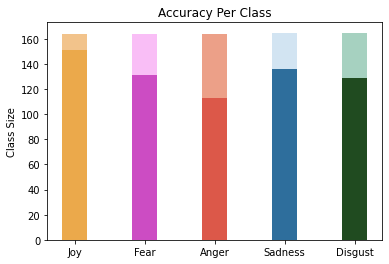

In [2]:
# stacked bar plot
import numpy as np
import matplotlib.pyplot as plt

emotion_labels = ['Joy', 'Fear', 'Anger', 'Sadness', 'Disgust']
total = [164, 164, 164, 165, 165]

score = [151, 131, 113, 136, 129]
error = []
for score_i, total_i in zip(score, total):
    error.append(total_i-score_i)

score_color = ['#EBA94B', '#CC4CC3', '#DC5849', '#2E6E9C', '#204B20']
error_color = ['#F2C38B', '#F9BEF6', '#ECA088', '#D2E4F2', '#A6D1C0']

width = 0.35
fig, ax = plt.subplots()

ax.bar(emotion_labels, score, width, color=score_color)
ax.bar(emotion_labels, error, width, bottom=score, color=error_color)

ax.set_ylabel('Class Size')
ax.set_title('Accuracy Per Class')

plt.show()